In [144]:
## import numpy as np
import matplotlib.pyplot as plt
import nnpy.Izhtools as it
import nnpy.visu_tools as visu

## two cell interaction  
Test, exc-exc cell

In [249]:
color_codes = ['#a31212', '#243cbf']

def draw_spk(**kwargs):
    for i in range(2):
        for t in obj2.t_spks[i]:
            plt.plot([t, t], yl, c=color_codes[i], **kwargs)

In [250]:
obj2 = it.Reader("../data/two_cell_ntk")
obj2.read_uv()
obj2.read_ic()
obj2.read_r()
obj2.read_tspk()

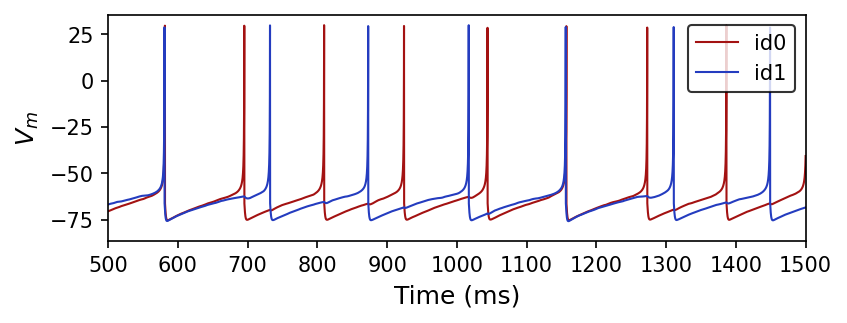

In [251]:
plt.figure(dpi=150, figsize=(6, 2))
for i in range(2):
    plt.plot(obj2.ts, obj2.vs[:, i], lw=1, c=color_codes[i], label='id%d'%(i))
plt.legend(fontsize=10, edgecolor='k')
plt.xlim([500, 1500])
plt.xticks(np.arange(500, 1600, 100))
plt.xlabel(r"Time (ms)", fontsize=12)
plt.ylabel(r"$V_{m}$", fontsize=12)
plt.show()

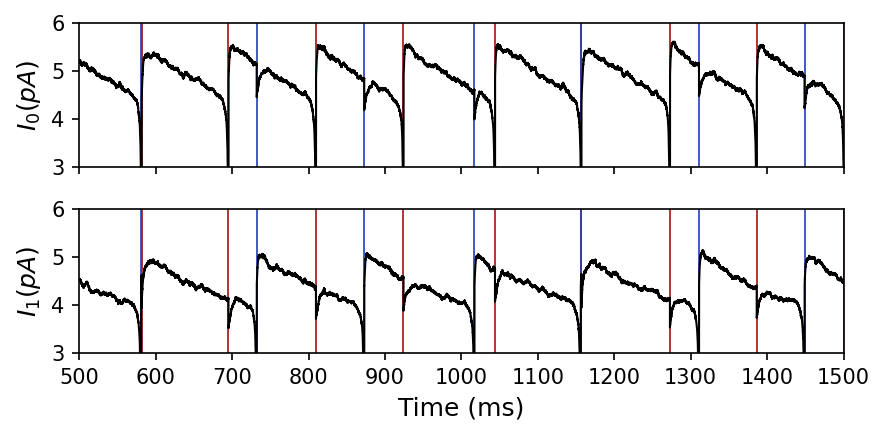

In [252]:
xl = [500, 1500]
yl = [3, 6]

plt.figure(dpi=150, figsize=(6, 3))
for n in range(2):
    plt.subplot(2,1,n+1)
    
    draw_spk(lw=0.8)

    plt.plot(obj2.ts, obj2.ics[:, n], lw=1, c='k')
    plt.xlim(xl)
    plt.ylim(yl)
    
    if n == 0:
        plt.xticks(np.arange(500, 1600, 100), labels=[])
    else:
        plt.xticks(np.arange(500, 1600, 100))
    plt.ylabel(r"$I_{%d} (pA)$"%(n), fontsize=12)
        
plt.xlabel("Time (ms)", fontsize=12)
        
plt.tight_layout()
plt.show()

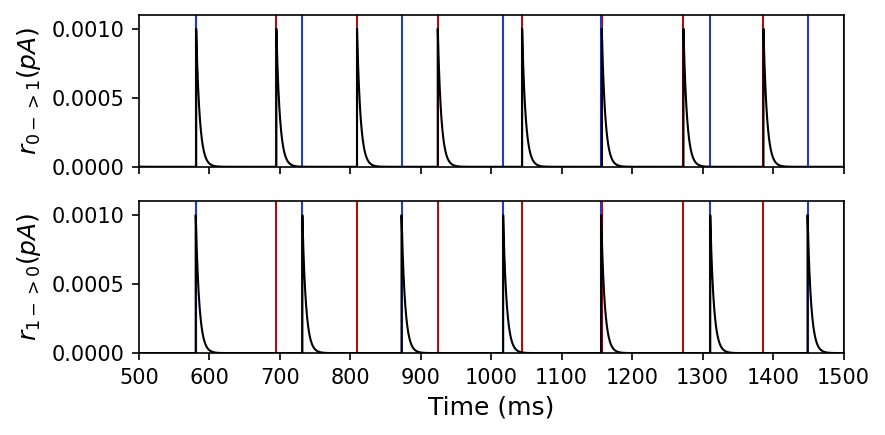

In [254]:
xl = [500, 1500]
yl = [0, 0.0011]

plt.figure(dpi=150, figsize=(6, 3))
for n in range(2):
    plt.subplot(2,1,n+1)
    
    draw_spk(lw=1)
    plt.plot(obj2.ts, obj2.rs[:, n], lw=1, c='k')
    plt.xlim(xl)
    plt.ylim(yl)
    
    if n == 0:
        plt.xticks(np.arange(500, 1600, 100), labels=[])
    else:
        plt.xticks(np.arange(500, 1600, 100))
    plt.ylabel(r"$r_{%d->%d} (pA)$"%(n, 1-n), fontsize=12)
    
    yt = plt.gca().get_yticks()
#     plt.yticks(yt, ['%.2e'%(x) for x in yt])
        
plt.xlabel("Time (ms)", fontsize=12)
        
plt.tight_layout()
plt.show()

## Multiple cell network

In [134]:
obj_ntk = it.Reader("../data/single_ntk")
obj_ntk.read_uv()
obj_ntk.read_tspk()
obj_ntk.read_ic()

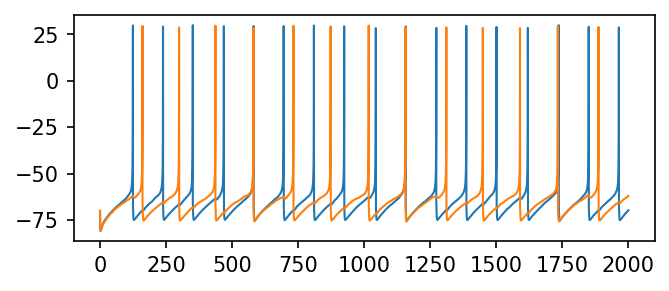

In [135]:
plt.figure(dpi=150, figsize=(5,2))
plt.plot(obj_ntk.ts, obj_ntk.vs[:, :4], lw=1)
plt.show()

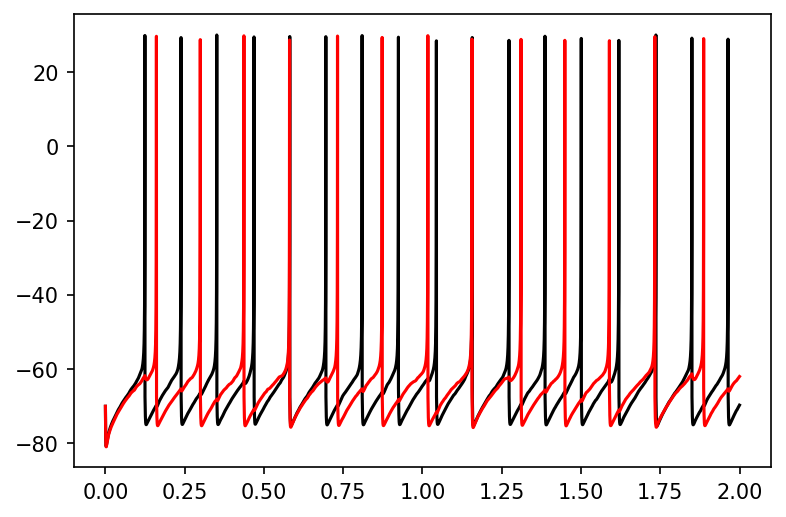

In [136]:
plt.figure(dpi=150)
plt.plot(obj_ntk.ts/1000, obj_ntk.vs[:, 0], 'k')
plt.plot(obj_ntk.ts/1000, obj_ntk.vs[:, 1], 'r')

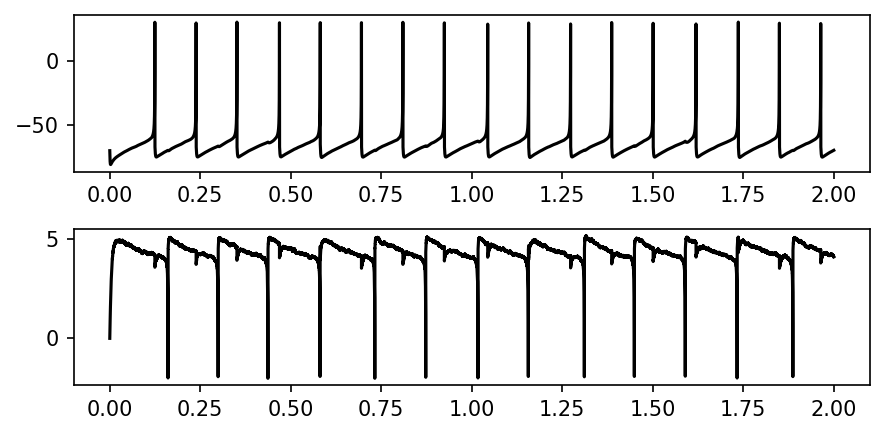

In [143]:
nid = 1

plt.figure(dpi=150, figsize=(6, 3))
plt.subplot(211)
plt.plot(obj_ntk.ts/1000, obj_ntk.vs[:, 0], 'k')

plt.subplot(212)
plt.plot(obj_ntk.ts/1000, obj_ntk.ics[:, 1], 'k')

plt.tight_layout()
plt.show()

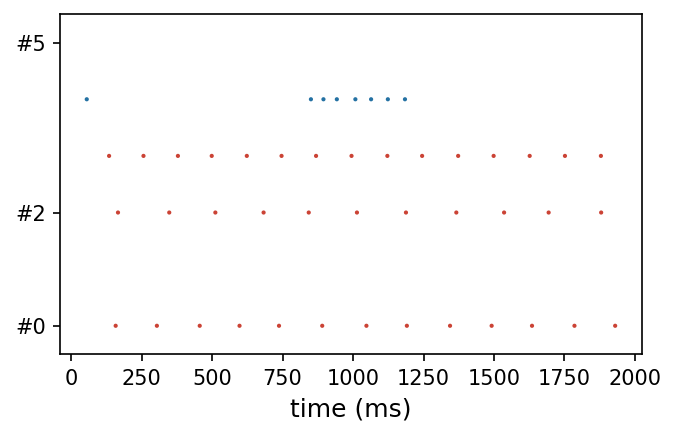

In [114]:
plt.figure(dpi=150, figsize=(5,3))
visu.draw_raster_plot(obj_ntk.t_spks, cell_types=obj_ntk.cell_types)
plt.ylim([-0.5, 5.5])
plt.show()